In [1]:
push!(LOAD_PATH, joinpath(@__DIR__, "../../lib"));

In [2]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot

In [3]:
using MSSim
const Opts = MSSim.Optimizers
const SS = MSSim.SegSeq
const SL = MSSim.SymLinear
const Seq = MSSim.Sequence

MSSim.Sequence

In [4]:
const radial_modes = [
    2.349490,
    2.397870,
    2.439980,
    2.476530,
    2.507130,
    2.531490,
    2.548960
];
const lamb_dicke_parameters = [
    0.12535185674701685,
    0.12411265750465082,
    0.12305413516480627,
    0.12216335005557813,
    0.12143343371677694,
    0.12086534864431214,
    0.12047167276221905
];
const participation_factors = [
    0.02222009251306859 -0.1722648656984975 0.48939776715759997 -0.678705987944334 0.4893977671575958 -0.17226486569849606 0.022220092513065576
    -0.08507556148734259 0.4120558633416861 -0.5683063560469468 0.0 0.5683063560469427 -0.4120558633416741 0.08507556148733478
    -0.21303936535968387 0.5714074376873661 -0.11990319870608773 -0.4769297472432097 -0.1199031987060997 0.5714074376873872 -0.2130393653596884
    0.39521513624944005 -0.44499802171470876 -0.38181377234109953 0.0 0.38181377234109876 0.4449980217146981 -0.39521513624943017
    0.5579098076201139 -0.031003440845807535 -0.3213345695440472 -0.41114359446049004 -0.3213345695440565 -0.031003440845817597 0.5579098076201152
    -0.5801440725517667 -0.3635749250921281 -0.1767657459105281 0.0 0.176765745910517 0.3635749250921191 0.5801440725517734
    0.37796447300922137 0.37796447300923375 0.37796447300922364 0.3779644730092235 0.37796447300922775 0.37796447300923464 0.37796447300922603
];

In [5]:
const modes = Seq.Modes()
const ion1 = 2
const ion2 = 6
for i in 1:7
    push!(modes, 2π * radial_modes[i], participation_factors[i, ion1] * participation_factors[i, ion2] * lamb_dicke_parameters[i]^2)
end

In [6]:
function blackman_start_end(x)
    if -0.5 <= x <= 0.5
        return 1.0
    elseif x < 0
        x = (x + 0.5) * 2
    else
        x = (x - 0.5) * 2
    end
    return 0.42 + 0.5 * cospi(x) + 0.08 * cospi(2 * x)
end

blackman_start_end (generic function with 1 method)

In [7]:
const nseg = 120
const buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
const buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

In [8]:
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

In [9]:
const nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));

In [10]:
const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
Opts.set_bound!(tracker, nlmodel.param.τ, 0.1, 2)
Opts.set_bound!(tracker, nlmodel.param.Ωs[1], 0.2, 0.4)
for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, 2π * 2.39, 2π * 2.52)
end

In [11]:
# const opt = NLopt.Opt(:LD_SLSQP, nargs)
const opt = NLopt.Opt(:LD_LBFGS, nargs)
# NLopt.xtol_rel!(opt, 1e-5)
# NLopt.ftol_rel!(opt, 1e-5)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

In [12]:
best_obj = 100.0
best_params = nothing
@time for i in 1:50
    global best_obj, best_params
    obj, params, ret = @time NLopt.optimize(opt, Opts.init_vars!(tracker))
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωbase],
        )
        println(best_status)
        best_params = params
    end
end

  3.133206 seconds (10.45 M allocations: 515.022 MiB, 7.03% gc time, 99.58% compilation time)
  0.013186 seconds (1.93 k allocations: 103.312 KiB)
  0.014863 seconds (2.26 k allocations: 121.031 KiB)
  0.323850 seconds (22.44 k allocations: 1.157 MiB)
(obj = 4.194418312374564e-6, dis = 6.507747485523695e-14, disδ = 3.2039849959784994e-12, area = 1.570796297916986, areaε = -2.8877910507318916e-8, areaδ = -20.48027800483667, total_t = 185.51345008304824, Ωmax = 0.39999998999988834)
 10.000081 seconds (1.49 M allocations: 76.594 MiB, 0.31% gc time)
(obj = 3.35873603000522e-6, dis = 5.051638510193957e-14, disδ = 1.1261129048403822e-12, area = 1.5707963158607776, areaε = -1.0934118943595195e-8, areaδ = -18.3268539422528, total_t = 191.39822500569474, Ωmax = 0.4)
  0.113672 seconds (10.99 k allocations: 581.297 KiB)
 10.000213 seconds (1.55 M allocations: 80.081 MiB, 0.04% gc time)
  1.172435 seconds (185.65 k allocations: 9.563 MiB)
  0.212033 seconds (17.65 k allocations: 932.719 KiB)
  0.

In [13]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
println(opt_raw_params)

MSSim.Sequence.RawParams([2.0, -5.551115123125783e-18, 0.00019817207491355793, 0.0, 15.132719166192247, 2.0, 0.0003963441498271103, 0.0006037951739874898, 30.265438332384495, 15.555667479693234, 2.0, 0.00160393449780209, 0.0010366530315827544, 61.37677329177096, 15.302181126285317, 2.0, 0.003677240560967599, 0.001512923656997833, 91.9811355443416, 15.595869334777241, 2.0, 0.006703087874963265, 0.002045915684074511, 123.17287421389608, 15.725055187066166, 2.0, 0.010794919243112287, 0.0026451128509482596, 154.6229845880284, 15.376252473616665, 2.0, 0.016085144945008806, 0.003315400392038632, 185.37548953526172, 15.203865227377639, 2.0, 0.02271594572908607, 0.004056511087288677, 215.783219990017, 15.464369588008413, 2.0, 0.030828967903663424, 0.00486271890892182, 246.7119591660338, 15.256549497828793, 2.0, 0.040554405721507064, 0.005722797139246449, 277.2250581616914, 15.15202835043879, 2.0, 0.05199999999999996, 0.006620245990678272, 307.529114862569, 15.610149573885666, 2.0, 0.0652404919

In [14]:
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

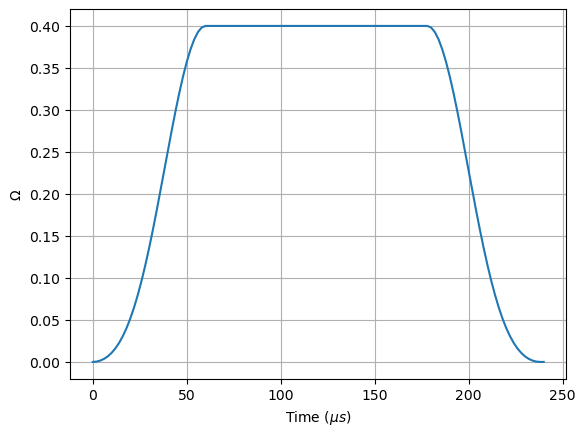

In [15]:
plot(Seq.get_Ωs(opt_raw_params)...)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\Omega$")
grid()

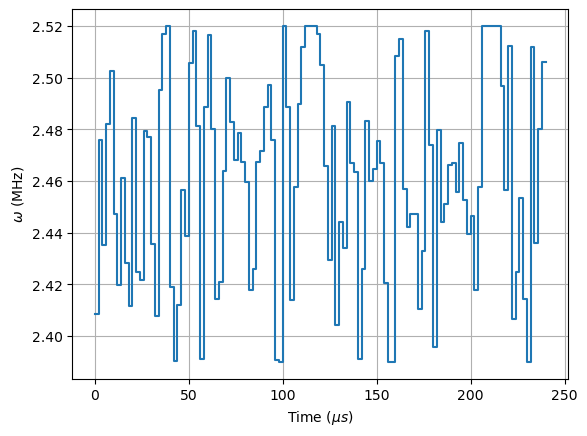

In [16]:
ts, ωs = Seq.get_ωs(opt_raw_params)
plot(ts, ωs ./ 2π)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\omega$ (MHz)")
grid()

In [17]:
Seq.total_dis(kern, opt_raw_params, modes)

1.2820609676304486e-14

In [18]:
Seq.total_cumdis(kern, opt_raw_params, modes)

7.654980874087865e-10

In [19]:
Seq.total_disδ(kern, opt_raw_params, modes)

2.706430633297404e-13

In [20]:
Seq.total_area(kern, opt_raw_params, modes)

1.5707963511957599

In [21]:
Seq.total_areaδ(kern, opt_raw_params, modes)

-8.331792979230684

In [22]:
plot_δs = range(-1, 1, 10001); # kHz

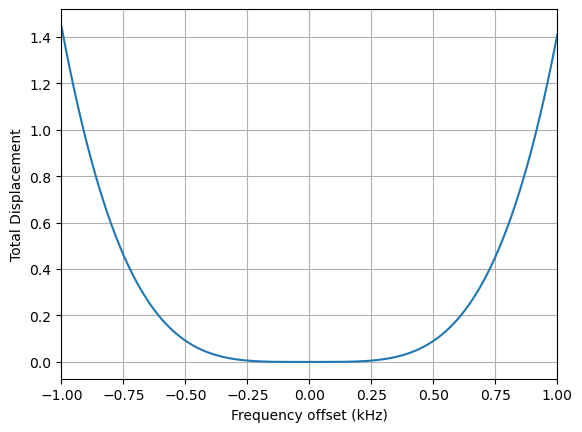

In [23]:
plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()

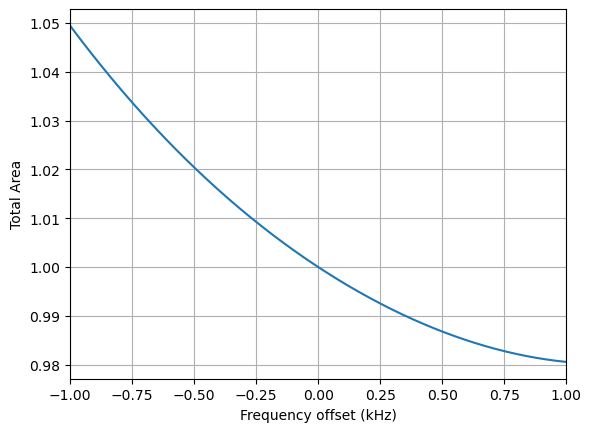

In [24]:
area0 = Seq.total_area(kern, opt_raw_params, modes)
plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
xlim([-1, 1])
xlabel("Frequency offset (kHz)")
ylabel("Total Area")
grid()

In [25]:
_, xs1, ys1 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[1][1])
_, xs2, ys2 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[2][1])
_, xs3, ys3 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[3][1])
_, xs4, ys4 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[4][1])
_, xs5, ys5 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[5][1])
_, xs6, ys6 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[6][1])
_, xs7, ys7 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[7][1]);

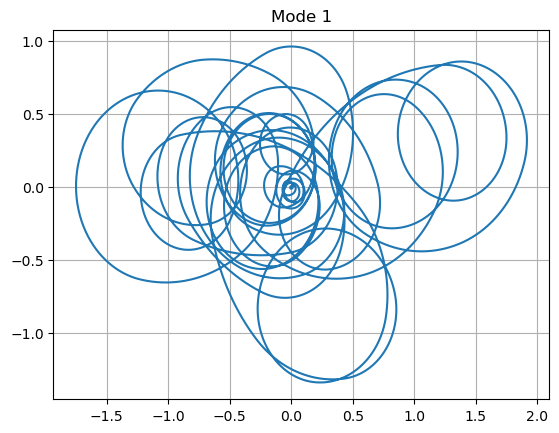

In [26]:
plot(xs1, ys1)
title("Mode 1")
grid()

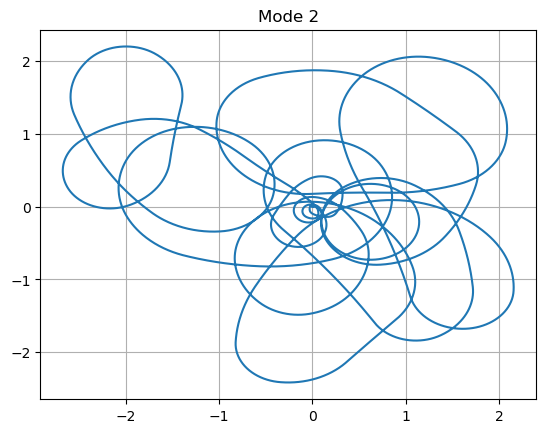

In [27]:
plot(xs2, ys2)
title("Mode 2")
grid()

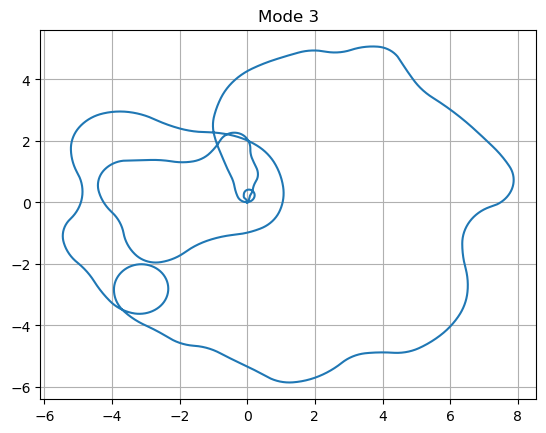

In [28]:
plot(xs3, ys3)
title("Mode 3")
grid()

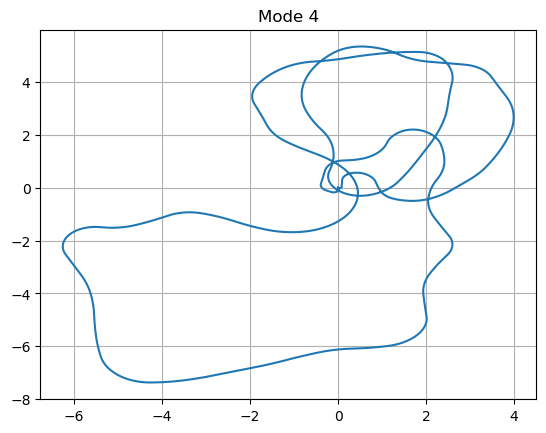

In [29]:
plot(xs4, ys4)
title("Mode 4")
grid()

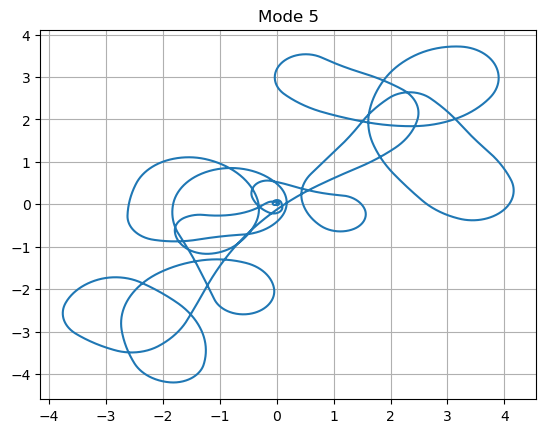

In [30]:
plot(xs5, ys5)
title("Mode 5")
grid()

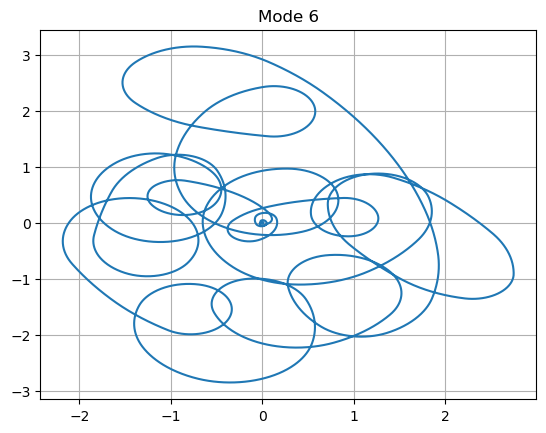

In [31]:
plot(xs6, ys6)
title("Mode 6")
grid()

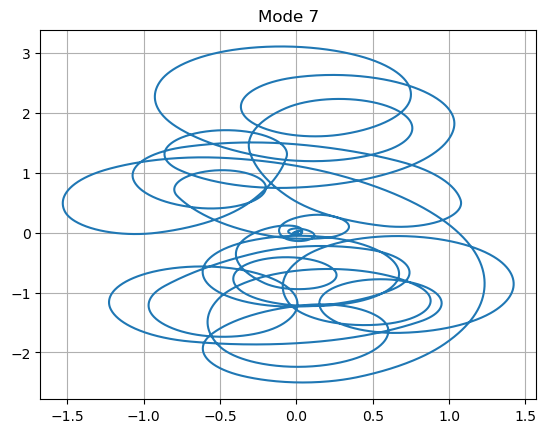

In [32]:
plot(xs7, ys7)
title("Mode 7")
grid()